In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel("/content/Assignment 3 - timeseries_data.xlsx")
df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


# Preprocess Data

In [3]:
# Check for missing values
df.isnull().sum()
# 'WIND_RTI' and 'GENERATION_SOLAR_RT' contain missing data

DATETIME                       0
HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               5
ERCOT (GENERATION_SOLAR_RT)    4
ERCOT (RTLOAD)                 0
HOURENDING                     0
MARKETDAY                      0
PEAKTYPE                       0
MONTH                          0
YEAR                           0
dtype: int64

In [4]:
# Fill or drop any missing values if necessary
df.fillna(method='ffill', inplace=True)

In [5]:
df.isnull().sum()

DATETIME                       0
HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               0
ERCOT (GENERATION_SOLAR_RT)    0
ERCOT (RTLOAD)                 0
HOURENDING                     0
MARKETDAY                      0
PEAKTYPE                       0
MONTH                          0
YEAR                           0
dtype: int64

In [6]:
df.describe()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,YEAR
count,14987,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987,14987.000000
mean,2017-11-09 06:41:09.340094720,25.766417,7533.323863,291.942802,42371.673703,12.495763,2017-11-08 18:11:24.593314304,2017.415493
min,2017-01-01 01:00:00,-17.860000,54.440000,0.000000,25566.511248,1.000000,2017-01-01 00:00:00,2017.000000
25%,2017-06-06 04:30:00,18.041250,4134.720000,0.000000,35431.636526,6.000000,2017-06-06 00:00:00,2017.000000
50%,2017-11-09 06:00:00,20.057500,7281.520000,22.070000,39934.007113,12.000000,2017-11-09 00:00:00,2017.000000
75%,2018-04-14 09:30:00,25.030000,10852.410000,608.580000,47873.100786,18.000000,2018-04-14 00:00:00,2018.000000
max,2018-09-17 12:00:00,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018-09-17 00:00:00,2018.000000
std,NaN,46.361945,3994.646804,370.890787,9874.339631,6.922309,NaN,0.492823


In [7]:
df2 = pd.get_dummies(df, columns=["PEAKTYPE", "MONTH", "YEAR"], drop_first = True)
for column in df2.select_dtypes(include='bool').columns:
    df2[column] = df2[column].astype(int)
df2.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK,MONTH_AUGUST,...,MONTH_FEBRUARY,MONTH_JANUARY,MONTH_JULY,MONTH_JUNE,MONTH_MARCH,MONTH_MAY,MONTH_NOVEMBER,MONTH_OCTOBER,MONTH_SEPTEMBER,YEAR_2018
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# Shift the data to make all values positive
shifted_values = df2['HB_NORTH (RTLMP)'] - df2['HB_NORTH (RTLMP)'].min() + 1
# Apply log transformation
df2['HB_NORTH (RTLMP)_log'] = np.log(shifted_values)
df2.describe()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK,MONTH_AUGUST,...,MONTH_JANUARY,MONTH_JULY,MONTH_JUNE,MONTH_MARCH,MONTH_MAY,MONTH_NOVEMBER,MONTH_OCTOBER,MONTH_SEPTEMBER,YEAR_2018,HB_NORTH (RTLMP)_log
count,14987,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987,14987.000000,14987.000000,14987.000000,...,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000
mean,2017-11-09 06:41:09.340094720,25.766417,7533.323863,291.942802,42371.673703,12.495763,2017-11-08 18:11:24.593314304,0.464803,0.201775,0.099286,...,0.099286,0.099286,0.096083,0.099153,0.099286,0.048108,0.049643,0.074465,0.415493,3.721072
min,2017-01-01 01:00:00,-17.860000,54.440000,0.000000,25566.511248,1.000000,2017-01-01 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-06-06 04:30:00,18.041250,4134.720000,0.000000,35431.636526,6.000000,2017-06-06 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.608245
50%,2017-11-09 06:00:00,20.057500,7281.520000,22.070000,39934.007113,12.000000,2017-11-09 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.661444
75%,2018-04-14 09:30:00,25.030000,10852.410000,608.580000,47873.100786,18.000000,2018-04-14 00:00:00,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.781687
max,2018-09-17 12:00:00,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018-09-17 00:00:00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.947402
std,NaN,46.361945,3994.646804,370.890787,9874.339631,6.922309,NaN,0.498776,0.401338,0.299056,...,0.299056,0.299056,0.294715,0.298877,0.299056,0.214002,0.217214,0.262534,0.492823,0.296700


In [9]:
scaled_df = df2
scaler = StandardScaler()
scaled_df[['ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)']] = scaler.fit_transform(df[['ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)']])
scaled_df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK,MONTH_AUGUST,...,MONTH_JANUARY,MONTH_JULY,MONTH_JUNE,MONTH_MARCH,MONTH_MAY,MONTH_NOVEMBER,MONTH_OCTOBER,MONTH_SEPTEMBER,YEAR_2018,HB_NORTH (RTLMP)_log
0,2017-01-01 01:00:00,23.3575,-1.346350,-0.787166,-1.305030,1,2017-01-01,0,0,0,...,1,0,0,0,0,0,0,0,0,3.742835
1,2017-01-01 02:00:00,21.4650,-1.306671,-0.787166,-1.363186,2,2017-01-01,0,0,0,...,1,0,0,0,0,0,0,0,0,3.696972
2,2017-01-01 03:00:00,20.7350,-1.238109,-0.787166,-1.431375,3,2017-01-01,0,0,0,...,1,0,0,0,0,0,0,0,0,3.678703
3,2017-01-01 04:00:00,20.2700,-1.197811,-0.787166,-1.473634,4,2017-01-01,0,0,0,...,1,0,0,0,0,0,0,0,0,3.666889
4,2017-01-01 05:00:00,20.1200,-1.195598,-0.787166,-1.491262,5,2017-01-01,0,0,0,...,1,0,0,0,0,0,0,0,0,3.663049


# Exploratory Data Analysis

In [10]:
# Convert 'DATETIME' to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [11]:
df.shape

(14987, 10)

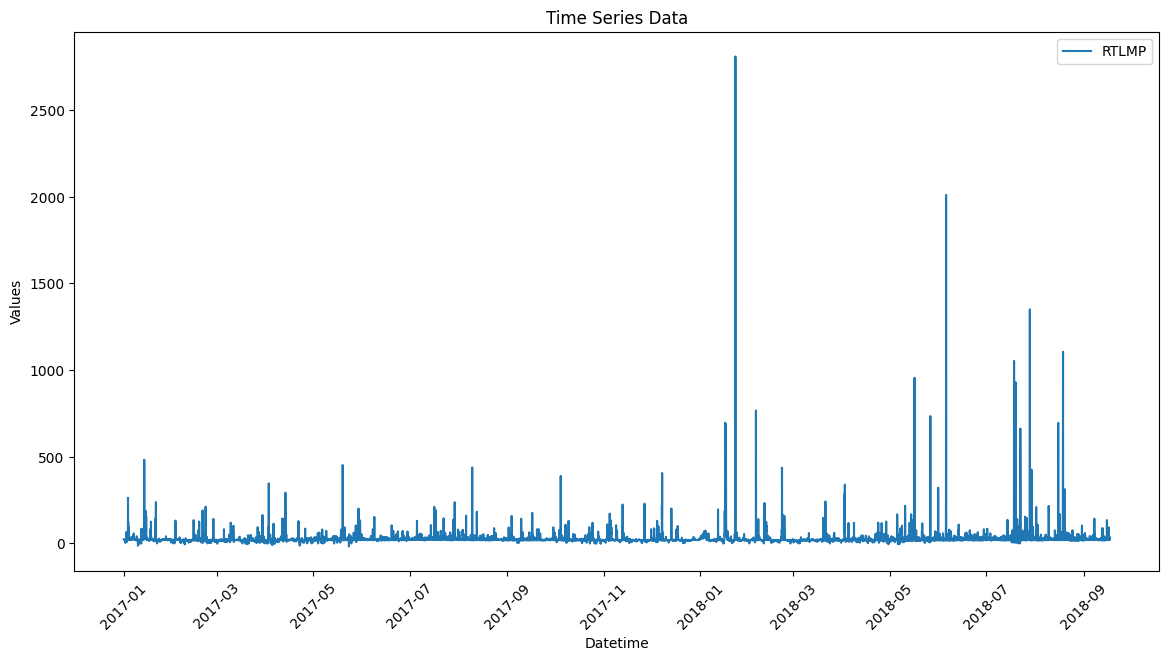

In [12]:
# Plotting the time series data
plt.figure(figsize=(14, 7))
plt.plot(df['DATETIME'], df['HB_NORTH (RTLMP)'], label='RTLMP')
plt.legend()
plt.title('Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

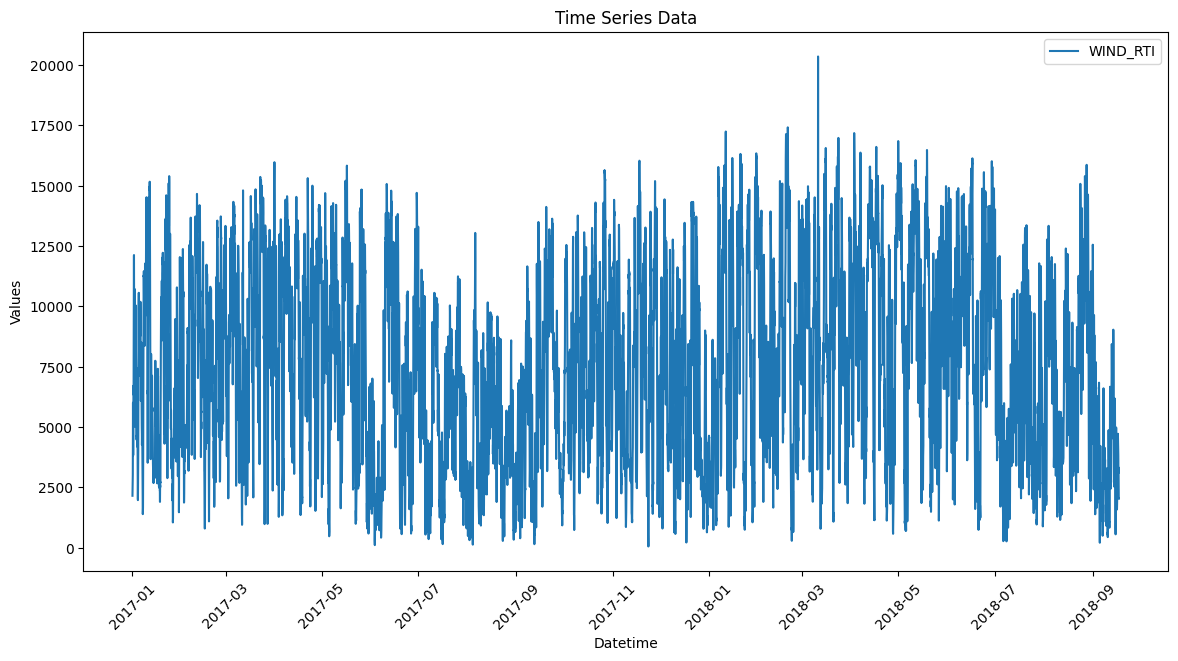

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df['DATETIME'], df['ERCOT (WIND_RTI)'], label='WIND_RTI')
plt.legend()
plt.title('Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

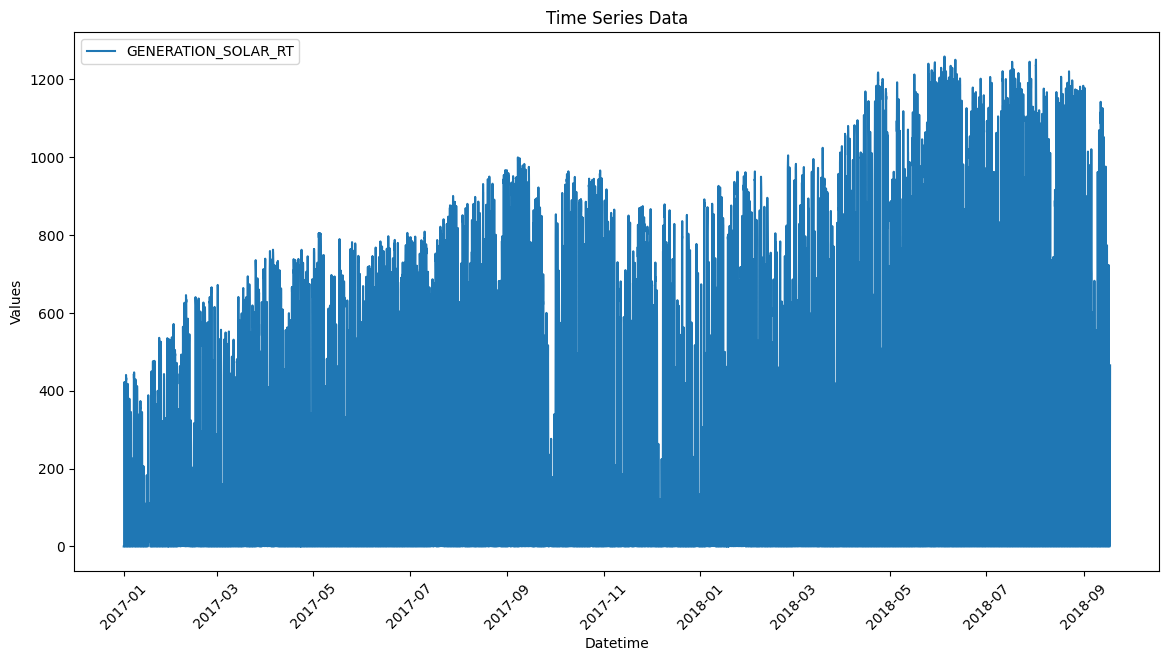

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df['DATETIME'], df['ERCOT (GENERATION_SOLAR_RT)'], label='GENERATION_SOLAR_RT')
plt.legend()
plt.title('Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

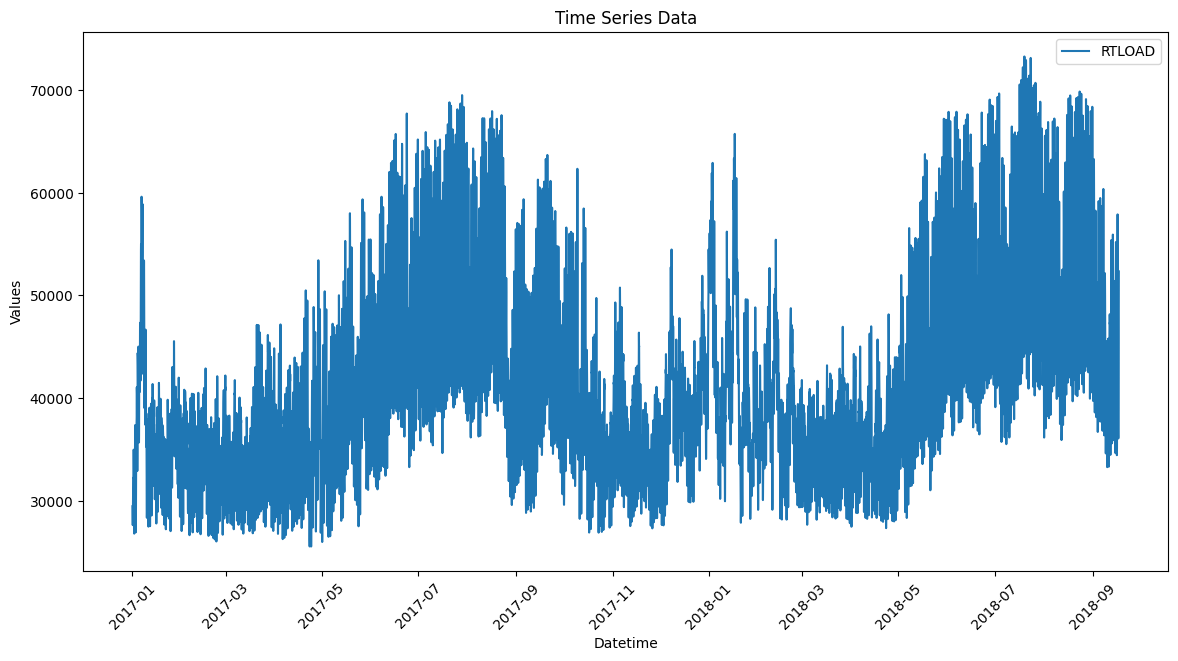

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df['DATETIME'], df['ERCOT (RTLOAD)'], label='RTLOAD')
plt.legend()
plt.title('Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

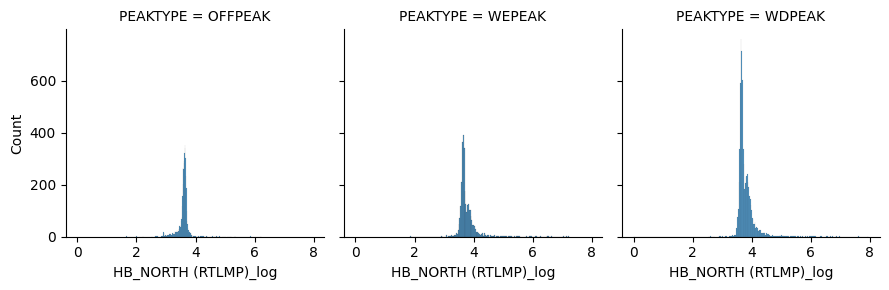

In [16]:
df['HB_NORTH (RTLMP)_log'] = df2['HB_NORTH (RTLMP)_log']
g = sns.FacetGrid(df, col="PEAKTYPE")
g.map(sns.histplot, "HB_NORTH (RTLMP)_log")

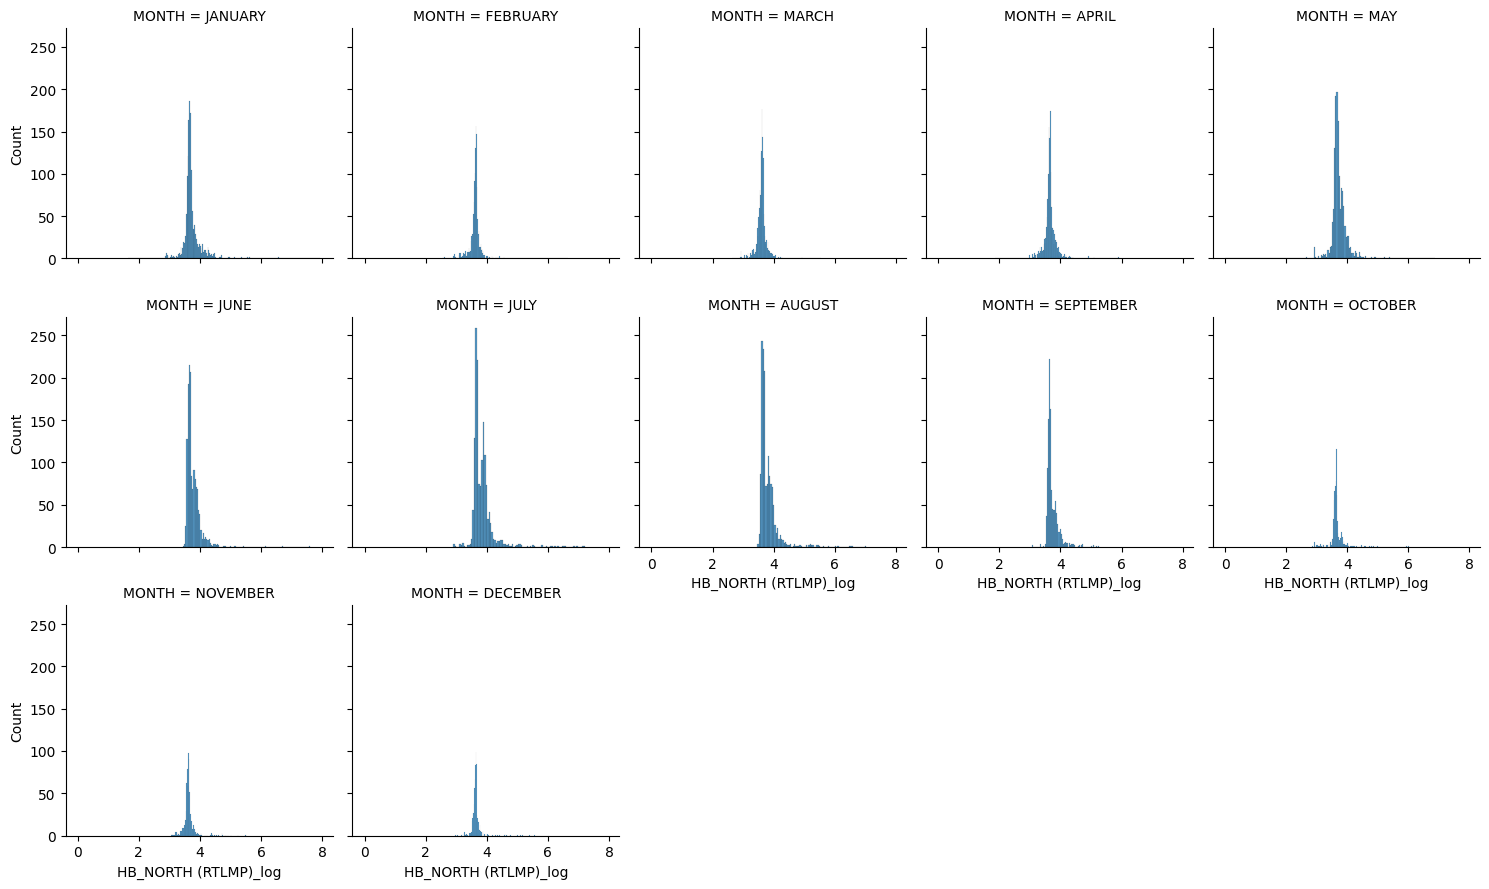

In [17]:
g = sns.FacetGrid(df, col="MONTH", col_wrap=5)
g.map(sns.histplot, "HB_NORTH (RTLMP)_log")

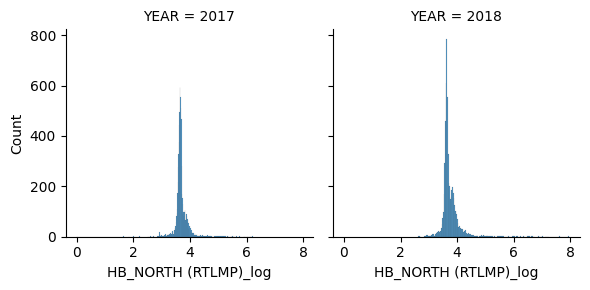

In [18]:
g = sns.FacetGrid(df, col="YEAR")
g.map(sns.histplot, "HB_NORTH (RTLMP)_log")

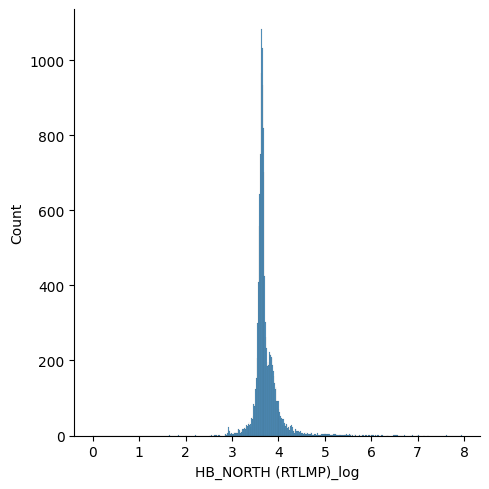

In [19]:
sns.displot(df2['HB_NORTH (RTLMP)_log'], kind = 'hist')
# The distribution is closer to the normal distribution after log transformation.

<Axes: >

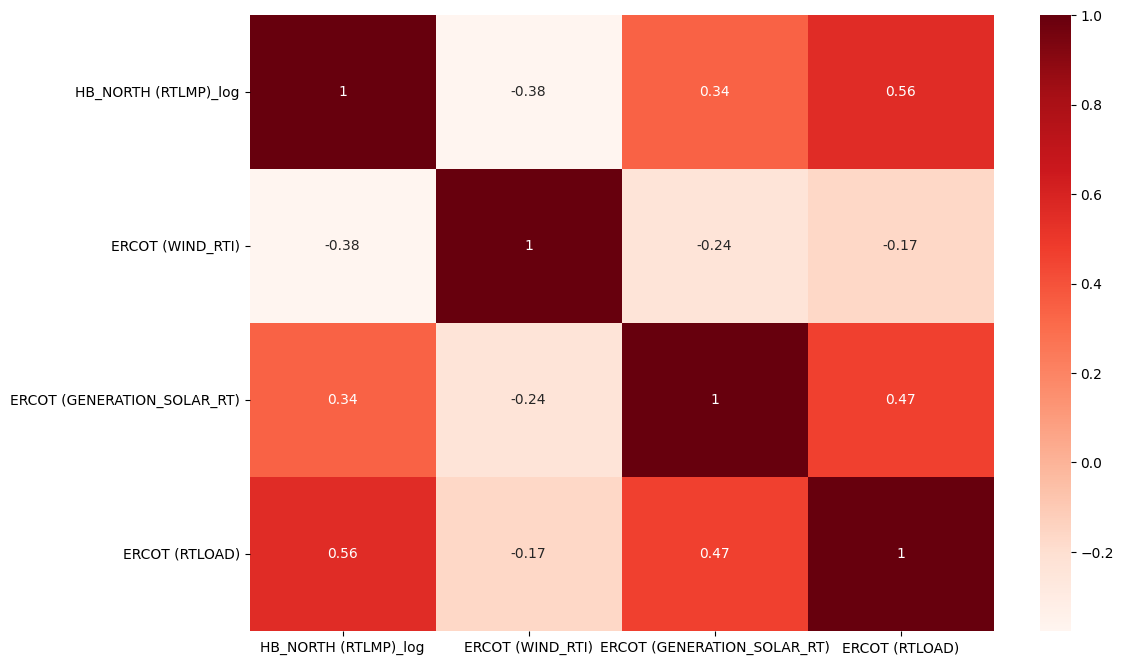

In [20]:
corr = scaled_df[['HB_NORTH (RTLMP)_log', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot = True, cmap="Reds")

1. The time series data for wind (WIND_RTI) and solar (GENERATION_SOLAR_RT) generation exhibit pronounced **seasonal and environmental influences**. Wind and solar outputs fluctuate naturally and predictably according to environmental conditions, affecting energy supply and, consequently, the RTLMP.
2. Wind generation shows **higher variability** than solar, characterized by rapid changes in output levels due to shifting wind speeds. In contrast, solar generation follows a more predictable daily pattern, primarily influenced by the sun's availability. Managing these differences is crucial for maintaining grid stability, especially during periods of low renewable output when there is increased dependence on non-renewable sources, which could drive up RTLMP.
3. **Correlation**: RTLMP's moderate positive correlation with load (0.56) underscores the direct impact of demand on electricity prices. The negative correlation (-0.38) between wind generation and RTLMP suggests that higher wind energy output can marginally reduce electricity prices. Contrarily, the positive correlation (0.34) between solar generation and RTLMP indicates that solar energy's contribution might elevate prices.

# Modelling

In [21]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)

df2.drop(['DATETIME', 'HB_NORTH (RTLMP)','HOURENDING', 'MARKETDAY'], axis = 1, inplace = True)
temp_Y = df2['HB_NORTH (RTLMP)_log']
temp_X = df2.drop(['HB_NORTH (RTLMP)_log'], axis = 1)
fit = bestfeatures.fit(temp_X,temp_Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(temp_X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

                          Specs        Score
2                ERCOT (RTLOAD)  6680.780091
0              ERCOT (WIND_RTI)  2482.999271
1   ERCOT (GENERATION_SOLAR_RT)  1982.827985
3               PEAKTYPE_WDPEAK   889.850236
9                    MONTH_JULY   303.585956
11                  MONTH_MARCH   227.743523
5                  MONTH_AUGUST   158.088921
16                    YEAR_2018   134.141408


In [22]:
Y = scaled_df['HB_NORTH (RTLMP)_log']
X = scaled_df.drop(['HB_NORTH (RTLMP)_log'], axis = 1)

validation_size = 0.2

seed = 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [23]:
scores_df = pd.DataFrame(index= ['r2','evs','mae','mse','mape'])
scores_df

""
r2
evs
mae
mse
mape


## Linear Regression

In [24]:
kfold = KFold(n_splits=4)
#converted mean square error to positive. The lower the beter
cv_results = cross_val_score(LinearRegression(), X_train, Y_train, cv=kfold, scoring='r2')
cv_results.mean()

0.44499141580605417

R-squared score : 0.162809
Explained variance score : 0.166895
Mean Absolute Error : 6.526087
Mean Squared error : 599.857285
Mean Absolute Percentage Error : 0.569035


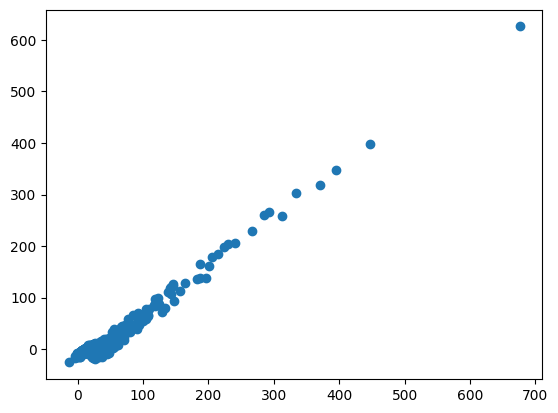

In [25]:
ols = LinearRegression().fit(X_train,Y_train)
y_pred_log = ols.predict(X_test)

min_val = df['HB_NORTH (RTLMP)'].min()
y_pred_original = np.exp(y_pred_log) + min_val - 1
y_test_original = np.exp( Y_test) + min_val - 1

ols_r2 = r2_score(y_test_original, y_pred_original)
ols_evs = explained_variance_score(y_test_original, y_pred_original)
ols_mae = mean_absolute_error(y_test_original, y_pred_original)
ols_mse = mean_squared_error(y_test_original, y_pred_original)
ols_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

ols = [ols_r2,ols_evs,ols_mae,ols_mse,ols_mape]
scores_df['OLS'] = ols

print("R-squared score : %f"% ols_r2)
print("Explained variance score : %f"% ols_evs)
print("Mean Absolute Error : %f"% ols_mae)
print("Mean Squared error : %f"% ols_mse)
print("Mean Absolute Percentage Error : %f"% ols_mape)
plt.scatter(y_test_original, y_test_original-y_pred_original)

## LASSO Regression

In [26]:
kfold_results = []
for a in np.arange(0.001,0.003,0.0002):
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(Lasso(alpha = a), X_train, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 0.001000, 0.439709
When alpha = 0.001200, 0.438591
When alpha = 0.001400, 0.437375
When alpha = 0.001600, 0.436015
When alpha = 0.001800, 0.434551
When alpha = 0.002000, 0.432956
When alpha = 0.002200, 0.431334
When alpha = 0.002400, 0.429834
When alpha = 0.002600, 0.428324
When alpha = 0.002800, 0.426692


R-squared score : 0.153884
Explained variance score : 0.158402
Mean Absolute Error : 6.488427
Mean Squared error : 606.252323
Mean Absolute Percentage Error : 0.580373


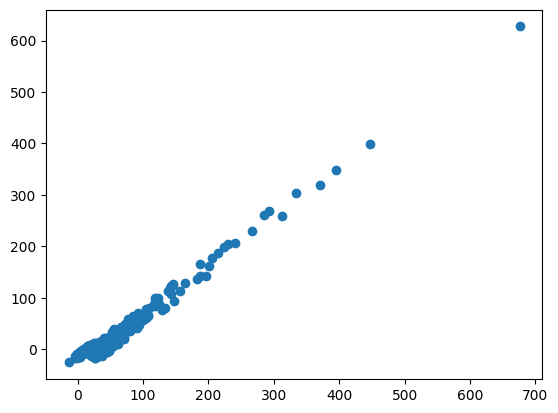

In [27]:
lasso = Lasso(alpha = 0.001).fit(X_train,Y_train)
y_pred_log = lasso.predict(X_test)

min_val = df['HB_NORTH (RTLMP)'].min()
y_pred_original = np.exp(y_pred_log) + min_val - 1
y_test_original = np.exp(Y_test) + min_val - 1

lasso_r2 = r2_score(y_test_original, y_pred_original)
lasso_evs = explained_variance_score(y_test_original, y_pred_original)
lasso_mae = mean_absolute_error(y_test_original, y_pred_original)
lasso_mse = mean_squared_error(y_test_original, y_pred_original)
lasso_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

lasso = [lasso_r2, lasso_evs, lasso_mae, lasso_mse, lasso_mape]
scores_df['Lasso'] = lasso

print("R-squared score : %f"% lasso_r2)
print("Explained variance score : %f"% lasso_evs)
print("Mean Absolute Error : %f"% lasso_mae)
print("Mean Squared error : %f"% lasso_mse)
print("Mean Absolute Percentage Error : %f"% lasso_mape)

plt.scatter(y_test_original, y_test_original-y_pred_original)

## Ridge

In [28]:
kfold_results = []
for a in np.arange(0.001,10,1):
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(Ridge(alpha = a), X_train, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 0.001000, 0.444991
When alpha = 1.001000, 0.444998
When alpha = 2.001000, 0.444997
When alpha = 3.001000, 0.444989
When alpha = 4.001000, 0.444974
When alpha = 5.001000, 0.444953
When alpha = 6.001000, 0.444927
When alpha = 7.001000, 0.444896
When alpha = 8.001000, 0.444860
When alpha = 9.001000, 0.444821


R-squared score : 0.162681
Explained variance score : 0.166776
Mean Absolute Error : 6.524328
Mean Squared error : 599.949100
Mean Absolute Percentage Error : 0.569218


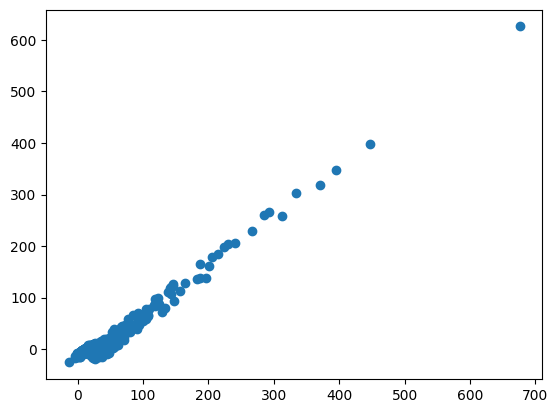

In [29]:
ridge = Ridge(alpha = 1.001).fit(X_train,Y_train)
predictions = ridge.predict(X_test)

y_pred_original = np.exp(predictions) + min_val - 1
y_test_original = np.exp(Y_test) + min_val - 1

ridge_r2 = r2_score(y_test_original, y_pred_original)
ridge_evs = explained_variance_score(y_test_original, y_pred_original)
ridge_mae = mean_absolute_error(y_test_original, y_pred_original)
ridge_mse = mean_squared_error(y_test_original, y_pred_original)
ridge_mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

ridge = [ridge_r2, ridge_evs, ridge_mae, ridge_mse, ridge_mape]
scores_df['Ridge'] = ridge

print("R-squared score : %f"% ridge_r2)
print("Explained variance score : %f"% ridge_evs)
print("Mean Absolute Error : %f"% ridge_mae)
print("Mean Squared error : %f"% ridge_mse)
print("Mean Absolute Percentage Error : %f"% ridge_mape)

plt.scatter(y_test_original, y_test_original-y_pred_original)

## ElasticNet

In [30]:
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5], 'l1_ratio': [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5]}

kfold = KFold(n_splits=4)
grid = GridSearchCV(ElasticNet(), param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.445004 using {'alpha': 0.0001, 'l1_ratio': 0.2}
0.444998 (0.007491) with: {'alpha': 0.0001, 'l1_ratio': 0.0001}
0.444998 (0.007491) with: {'alpha': 0.0001, 'l1_ratio': 0.001}
0.444999 (0.007494) with: {'alpha': 0.0001, 'l1_ratio': 0.01}
0.445002 (0.007522) with: {'alpha': 0.0001, 'l1_ratio': 0.1}
0.445004 (0.007553) with: {'alpha': 0.0001, 'l1_ratio': 0.2}
0.445002 (0.007583) with: {'alpha': 0.0001, 'l1_ratio': 0.3}
0.444996 (0.007614) with: {'alpha': 0.0001, 'l1_ratio': 0.4}
0.444987 (0.007645) with: {'alpha': 0.0001, 'l1_ratio': 0.5}
0.444821 (0.007783) with: {'alpha': 0.001, 'l1_ratio': 0.0001}
0.444819 (0.007785) with: {'alpha': 0.001, 'l1_ratio': 0.001}
0.444795 (0.007807) with: {'alpha': 0.001, 'l1_ratio': 0.01}
0.444518 (0.007983) with: {'alpha': 0.001, 'l1_ratio': 0.1}
0.444022 (0.008158) with: {'alpha': 0.001, 'l1_ratio': 0.2}
0.443498 (0.008324) with: {'alpha': 0.001, 'l1_ratio': 0.3}
0.443030 (0.008489) with: {'alpha': 0.001, 'l1_ratio': 0.4}
0.442467 (0.008575) with

R-squared score : 0.162470
Explained variance score : 0.166579
Mean Absolute Error : 6.522178
Mean Squared error : 600.100143
Mean Absolute Percentage Error : 0.569630


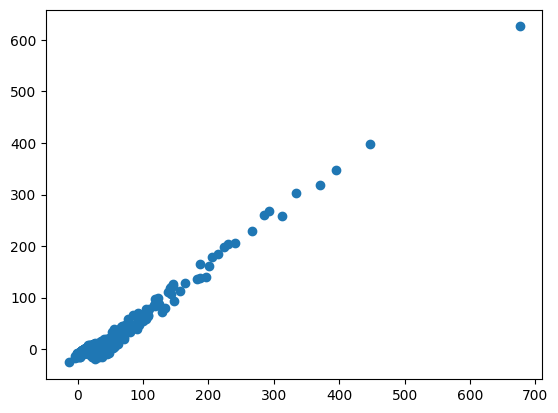

In [31]:
elastic = ElasticNet(alpha = 0.0001, l1_ratio = 0.2).fit(X_train,Y_train)
predictions = elastic.predict(X_test)

y_pred_original = np.exp(predictions) + min_val - 1
y_test_original = np.exp(Y_test) + min_val - 1

elastic_r2 = r2_score(y_test_original, y_pred_original)
elastic_evs = explained_variance_score(y_test_original, y_pred_original)
elastic_mae = mean_absolute_error(y_test_original, y_pred_original)
elastic_mse = mean_squared_error(y_test_original, y_pred_original)
elastic_mape  = mean_absolute_percentage_error(y_test_original, y_pred_original)

elastic = [elastic_r2, elastic_evs, elastic_mae, elastic_mse, elastic_mape]
scores_df['ElasticNet'] = elastic

print("R-squared score : %f"% elastic_r2)
print("Explained variance score : %f"% elastic_evs)
print("Mean Absolute Error : %f"% elastic_mae)
print("Mean Squared error : %f"% elastic_mse)
print("Mean Absolute Percentage Error : %f"% elastic_mape)

plt.scatter(y_test_original, y_test_original-y_pred_original)

## SVM

In [32]:
param_grid = {'C': np.arange(1, 3, 0.2), 'epsilon': np.arange(0.1, 0.5, 0.1)}

kfold = KFold(n_splits=4)
grid = GridSearchCV(SVR(), param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.542304 using {'C': 2.8, 'epsilon': 0.1}
0.532677 (0.003839) with: {'C': 1.0, 'epsilon': 0.1}
0.494016 (0.017212) with: {'C': 1.0, 'epsilon': 0.2}
0.357975 (0.041608) with: {'C': 1.0, 'epsilon': 0.30000000000000004}
0.115459 (0.070922) with: {'C': 1.0, 'epsilon': 0.4}
0.534754 (0.004518) with: {'C': 1.2, 'epsilon': 0.1}
0.495963 (0.018506) with: {'C': 1.2, 'epsilon': 0.2}
0.362810 (0.042706) with: {'C': 1.2, 'epsilon': 0.30000000000000004}
0.120780 (0.073026) with: {'C': 1.2, 'epsilon': 0.4}
0.536646 (0.005290) with: {'C': 1.4, 'epsilon': 0.1}
0.497859 (0.019625) with: {'C': 1.4, 'epsilon': 0.2}
0.366487 (0.043887) with: {'C': 1.4, 'epsilon': 0.30000000000000004}
0.125375 (0.074789) with: {'C': 1.4, 'epsilon': 0.4}
0.538037 (0.006028) with: {'C': 1.5999999999999999, 'epsilon': 0.1}
0.499348 (0.020946) with: {'C': 1.5999999999999999, 'epsilon': 0.2}
0.370528 (0.044331) with: {'C': 1.5999999999999999, 'epsilon': 0.30000000000000004}
0.129175 (0.076724) with: {'C': 1.59999999999999

R-squared score : 0.289458
Explained variance score : 0.296420
Mean Absolute Error : 5.463976
Mean Squared error : 509.111825
Mean Absolute Percentage Error : 0.434338


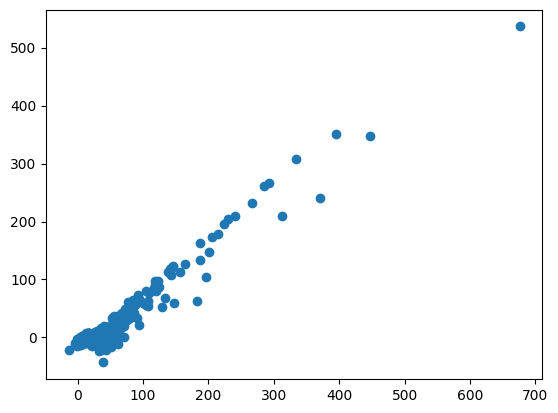

In [33]:
svr = SVR(C = 2.8, epsilon = 0.1).fit(X_train,Y_train)
predictions = svr.predict(X_test)

y_pred_original = np.exp(predictions) + min_val - 1
y_test_original = np.exp(Y_test) + min_val - 1

svr_r2 = r2_score(y_test_original, y_pred_original)
svr_evs = explained_variance_score(y_test_original, y_pred_original)
svr_mae = mean_absolute_error(y_test_original, y_pred_original)
svr_mse = mean_squared_error(y_test_original, y_pred_original)
svr_mape  = mean_absolute_percentage_error(y_test_original, y_pred_original)

svr = [svr_r2, svr_evs, svr_mae, svr_mse, svr_mape]
scores_df['SVR'] = svr

print("R-squared score : %f"% svr_r2)
print("Explained variance score : %f"% svr_evs)
print("Mean Absolute Error : %f"% svr_mae)
print("Mean Squared error : %f"% svr_mse)
print("Mean Absolute Percentage Error : %f"% svr_mape)

plt.scatter(y_test_original, y_test_original-y_pred_original)

## Polynomial Regression

In [ ]:
kfold_results = []
for a in range(1,6):
    poly_reg = PolynomialFeatures(degree=a)
    X_train_poly = poly_reg.fit_transform(X_train)
    kfold = KFold(n_splits=4)
    cv_results = cross_val_score(LinearRegression(), X_train_poly, Y_train, cv=kfold, scoring='r2')
    kfold_results.append(cv_results.mean())
    print("When alpha = %f, %f" %(a, cv_results.mean()))

When alpha = 1.000000, 0.444991
When alpha = 2.000000, 0.492759
When alpha = 3.000000, 0.538906
When alpha = 4.000000, -733648310451.490845
When alpha = 5.000000, -2271920241778.099609


R-squared score : 0.306495
Explained variance score : 0.310520
Mean Absolute Error : 5.926488
Mean Squared error : 496.904575
Mean Absolute Percentage Error : 0.426693


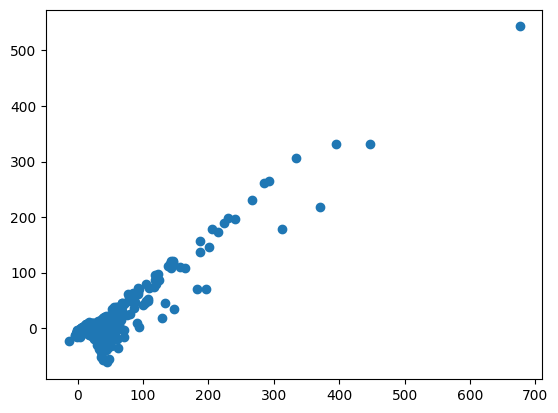

In [34]:
poly_reg = PolynomialFeatures(degree=3)
X_train_poly = poly_reg.fit_transform(X_train)

prm = LinearRegression().fit(X_train_poly, Y_train)
predictions = prm.predict(poly_reg.fit_transform(X_test))

y_pred_original = np.exp(predictions) + min_val - 1
y_test_original = np.exp(Y_test) + min_val - 1

prm_r2 = r2_score(y_test_original, y_pred_original)
prm_evs = explained_variance_score(y_test_original, y_pred_original)
prm_mae = mean_absolute_error(y_test_original, y_pred_original)
prm_mse = mean_squared_error(y_test_original, y_pred_original)
prm_mape  = mean_absolute_percentage_error(y_test_original, y_pred_original)

prm = [prm_r2, prm_evs, prm_mae, prm_mse, prm_mape]
scores_df['Polynomial Regression'] = prm

print("R-squared score : %f"% prm_r2)
print("Explained variance score : %f"% prm_evs)
print("Mean Absolute Error : %f"% prm_mae)
print("Mean Squared error : %f"% prm_mse)
print("Mean Absolute Percentage Error : %f"% prm_mape)

plt.scatter(y_test_original, y_test_original-y_pred_original)

In [35]:
pd.options.display.float_format = "{:,.4f}".format
scores_df

,OLS,Lasso,Ridge,ElasticNet,SVR,Polynomial Regression
r2,0.1628,0.1539,0.1627,0.1625,0.2895,0.3065
evs,0.1669,0.1584,0.1668,0.1666,0.2964,0.3105
mae,6.5261,6.4884,6.5243,6.5222,5.4640,5.9265
mse,599.8573,606.2523,599.9491,600.1001,509.1118,496.9046
mape,0.5690,0.5804,0.5692,0.5696,0.4343,0.4267


1. Polynomial Regression and SVR outperform the linear models in terms of both error metrics and explanatory power. This suggests that the relationship between the dependent and independent variables is likely non-linear.
2. Given the performance of Polynomial Regression and SVR, it may be beneficial to further explore and tune these models for better performance.
3. Adding more non-linear terms or interaction terms might help improve model performance.